## Preprocessing of imaging data
### Load, parse metadata and generate data object

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as ppatch
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari

#for roi generation
import shapely as sp
from shapely.geometry.polygon import LinearRing, Polygon, LineString

In [2]:
from fly2p.viz.viz import myAxisTheme

import fly2p.preproc.imgPreproc as imp

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

### Set paths to data files and plot directory

In [3]:
dataDir = '../../../../data/EPG/SS96_x_7f/f01'#'../sample' # dFB/84C10_x_7f/f02
rawTiff = 'SS96-x-7f_f01_3-5d_EB_2LM_00001.tif'#'84C10-x-7f_f02_4-5d_FB_dark_00001.tif'#'SS96_x_7f_25per_allProjectorsOn_00002.tif'
plotDir = sep.join([sep.join(dataDir.split(sep)[0:-2]), 'plot'])

print(dataDir)
print(plotDir)

../../../../data/EPG/SS96_x_7f/f01
../../../../data/EPG/plot


In [4]:
genotype = rawTiff.split('_')[0]
[flyID, age, region] = rawTiff.split('_')[1:4]
condition = rawTiff.split('_')[-2]
trial = rawTiff.split('_')[-1][:-4]
print(genotype, region, flyID, age, condition, trial)

SS96-x-7f EB f01 3-5d 2LM 00001


In [5]:
# Generate directory where to save plots
saveDir = sep.join([plotDir,genotype, condition])
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

../../../../data/EPG/plot/SS96-x-7f/2LM


### Load tiff file

#### Extract relevant information from header

In [6]:
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict

In [7]:
#with ScanImageTiffReader("data/resj_00001.tif") as reader:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))

metadat = mytiffreader.metadata()

basicMetadat = getSIbasicMetadata(metadat)

# give channel identity
basicMetadat["CaCh"] = 0
SImetadict = getSIMetadict(metadat)

#print(mytiffreader.metadata())

basicMetadat

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'
SI.hChannels.channelSave = 1


{'nCh': 1,
 'fpsscan': 38.1043,
 'discardFBFrames': 'false',
 'nDiscardFBFrames': 0,
 'fpv': 7,
 'nVols': 1400,
 'stackZStepSize': 9,
 'scanVolumeRate': 5.44347,
 'fovCoords': [array([-25.3125, -25.3125]),
  array([25.3125, 25.3125]),
  array([ 25.3125, -25.3125]),
  array([-25.3125,  25.3125])],
 'xrange_um': 50.625,
 'yrange_um': 50.625,
 'CaCh': 0}

#### Read and reshape image tiff stack

In [8]:
vol = mytiffreader.data()
volshape = vol.shape
print(volshape)

vol = vol.reshape((int(volshape[0]/(basicMetadat['fpv']*basicMetadat['nCh'])),
                   basicMetadat['fpv'],basicMetadat['nCh'],volshape[1], volshape[2]))

print('Full dimensional stack: volumes, planes, channels, xpix, ypix')
print(vol.shape)

stack = vol[:,0:basicMetadat['fpv']-basicMetadat['nDiscardFBFrames'],basicMetadat['CaCh'],:,:]
print('Stack reduced to one color channel and flyback frames discrded: stack4d')
print(stack.shape)

(9800, 200, 200)
Full dimensional stack: volumes, planes, channels, xpix, ypix
(1400, 7, 1, 200, 200)
Stack reduced to one color channel and flyback frames discrded: stack4d
(1400, 7, 200, 200)


In [9]:
import xarray as xr

volcoords = [i/basicMetadat['scanVolumeRate'] for i in range(stack.shape[0])]
slices = [i*basicMetadat['stackZStepSize'] for i in range(stack.shape[1])]
xpx = np.linspace(0, basicMetadat['xrange_um'], stack.shape[2])
ypx = np.linspace(0, basicMetadat['yrange_um'], stack.shape[3])
                  
imgStack = xr.DataArray(stack, coords = [volcoords, slices, xpx, ypx], 
                        dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])

imgStack

<xarray.DataArray (volumes [s]: 1400, planes [µm]: 7, xpix [µm]: 200, ypix [µm]: 200)>
array([[[[-33, -19, -11, ...,  -9, -17, -26],
         [ -7,  -7, -17, ...,   4,  -1,  -2],
         [ -7,  -2,   4, ..., -19, -18,  -5],
         ...,
         [-25, -23,  -9, ..., -10, -19, -23],
         [ -6,  -4, -21, ...,  -4,  -1,  -4],
         [ -8,   4,  -1, ..., -25, -17,  -2]],

        [[-14,  -4,   0, ..., -24, -27, -12],
         [-14, -25, -22, ...,  -2, -18, -10],
         [  0,   2,  -8, ..., -13,  -6,  -1],
         ...,
         [-14,  35,  21, ..., -25, -22, -17],
         [-16, -24, -22, ...,  -1,  -7, -12],
         [ -5,  -1, -12, ...,  -9,  -6,   3]],

        [[ -5,   8,  12, ..., -20, -13,  -6],
         [-29, -18, -12, ...,  -8, -22, -26],
         [ -4, -12, -23, ...,  -2,   8, -12],
         ...,
...
         ...,
         [ -8,  -9, -25, ...,   0,   7, -14],
         [ 42,   8,   1, ..., -20,  -9,  -4],
         [-29, -20, -13, ...,  -7,   8, -23]],

        [[-17, -27, -21, ...,  37,  -3, -19],
         [  1,  49,  17, ...,  -5,  -6,  25],
         [-15,  23,  48, ..., -28, -18, -15],
         ...,
         [ 37,  15,  32, ..., -12,  45, -24],
         [ -3,  -9, -14, ...,  -3,   8,  -6],
         [-12,  -5,   2, ..., -27, -15,  -5]],

        [[-17,  -5,  -5, ..., -16, -24,   7],
         [-13, -19, -26, ...,  30,   5, -16],
         [ -4,  -1, -10, ...,  -7,  -2,   2],
         ...,
         [ -6,  25,  -1, ...,  18,  12, -16],
         [ 49, -22, -22, ...,   5, -14, -18],
         [  5,  -1, -14, ..., -14,   3,   1]]]], dtype=int16)
Coordinates:
  * volumes [s]  (volumes [s]) float64 0.0 0.1837 0.3674 ... 256.6 256.8 257.0
  * planes [µm]  (planes [µm]) int64 0 9 18 27 36 45 54
  * xpix [µm]    (xpix [µm]) float64 0.0 0.2544 0.5088 ... 50.12 50.37 50.62
  * ypix [µm]    (ypix [µm]) float64 0.0 0.2544 0.5088 ... 50.12 50.37 50.62

Max projection along z-volumes

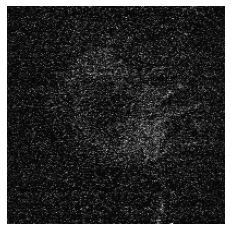

In [10]:
stackMP = imgStack.max(axis=1)
stackMP.shape
fig,ax = plt.subplots(1,1)
ax.imshow(stackMP[1],cmap='Greys_r',origin='lower')
ax.axis('off');

### Motion correction
#### Correct translation in x/y using phase correlation

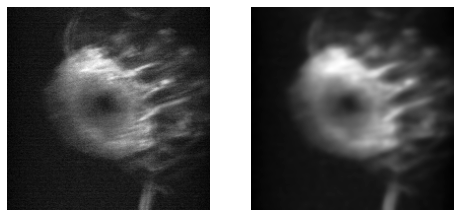

In [16]:
# Settings
## reference image
numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower')
axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower')
axs[1].axis('off');

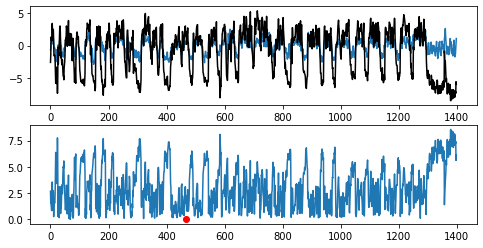

In [17]:
stackMPMC, shift = imp.motionCorrection(stackMP, refImg, 20, 2)

fig, axs = plt.subplots(2,1,figsize=(8,4))
axs[0].plot(shift[0,:])
axs[0].plot(shift[1,:],'k')
axs[1].plot(np.hypot(shift[0,:],shift[1,:]))
axs[1].plot(locRefImg,0,'ro')

#### Apply estimated motion to 4d stack
We assume here that all planes in a volume at a given time moved together

In [58]:
stack4dMC = imp.applyShiftTo4Dstack(imgStack, shift)

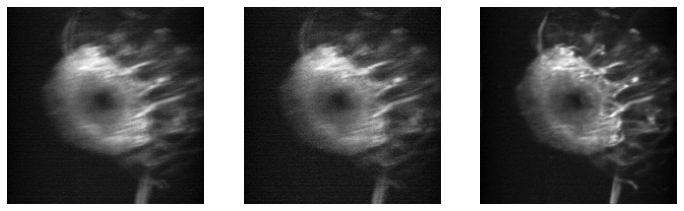

In [19]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(stack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
axs[0].axis('off');
axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
axs[1].axis('off');
axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
axs[2].axis('off');

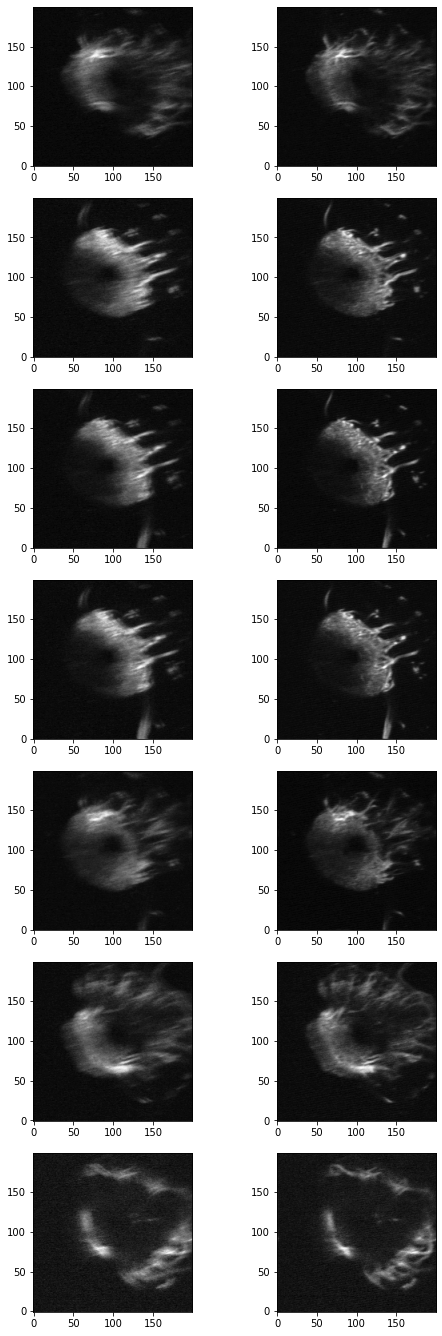

In [22]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2, figsize=(8, 24))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i,0].imshow(imgStack[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,1].imshow(stack4dMC[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')

### Perform correlation analysis to get ROIs

#### (1) Define regions on which to perform clustering
Mark the area that should be considered with the napari labeling tool in a layer named "mask".

(a) Single plane mask for max projection

In [28]:
viewer = napari.view_image(refImgFilt)

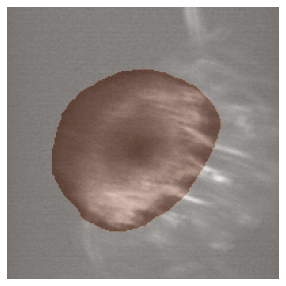

In [40]:
# you can draw a mask:
#mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r', vmin=0, origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.4)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, age, condition, trial])+'.pdf')

(b) 3D mask for volume processing

In [31]:
refStack = stack4dMC[0,:,:,:]
for i in range(stack4dMC["planes [µm]"].size):
    refStack[i,:,:] = stack4dMC[:,i,:,:].mean(axis=0)
    
viewer3D = napari.view_image(refStack)

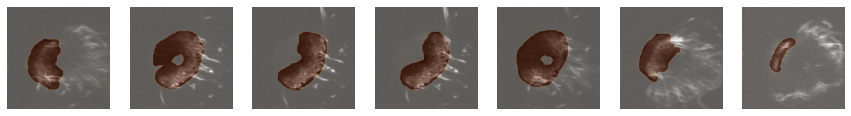

In [45]:
mask3D = viewer3D.layers["mask"]

fig, ax = plt.subplots(1,stack4dMC["planes [µm]"].size, figsize=(15,4))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i].imshow(refStack[i,:,:],cmap='Greys_r',origin='lower')  
    ax[i].axis('off');
    ax[i].imshow(mask3D.data[i,:,:], cmap='Oranges', alpha=0.35)
    
fig.savefig(saveDir+sep+'_'.join(['mask3D',genotype, region, flyID, age, condition, trial])+'.pdf')

#### (2) Compute DFF

In [119]:
# Settings
# filter DF/F trace with Savitzky-Golay filter
from scipy.signal import savgol_filter

# 3rd order, 7 frames
order = 3
window = 7

# Currently F_0 is estimated for the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

(a) one plane

In [140]:
dffStackMC = np.zeros((stackMPMC.shape)) 

filtStack = gaussian_filter(stackMPMC, sigma=[0,2,2])

for x in range(stackMPMC["xpix [µm]"].size):
    for y in range(stackMPMC["ypix [µm]"].size):
        
        if mask.data[x,y] == 0:
            continue
            
        filtF = savgol_filter(filtStack[:,x,y], window, order)

        # Estimate baseline
        F0 = np.percentile(filtF, baseLinePercent)
        if F0 == 0: F0 += offset

        # Compute dF/F_0 = (F_raw - F_0)/F_0
        dFF = (filtF - F0) / F0

        dffStackMC[:,x,y] = dFF

(-0.5, 199.5, 199.5, -0.5)

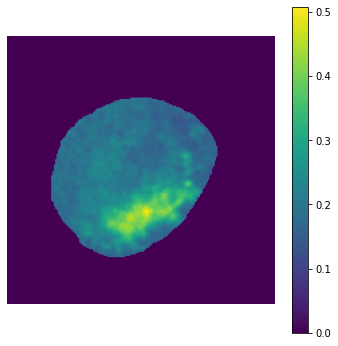

In [48]:
dffMP = np.median(dffStackMC,axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,6))
cb = ax.imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb)
ax.axis('off')

#viewerdff = napari.view_image(dffStackMC)

Volume

(-0.5, 199.5, 199.5, -0.5)

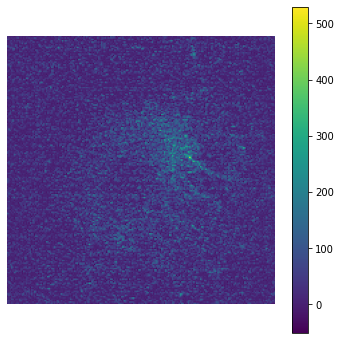

In [114]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cb = ax.imshow(stackMPMC[10,:,:],cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb)
ax.axis('off')

(-0.5, 199.5, 199.5, -0.5)

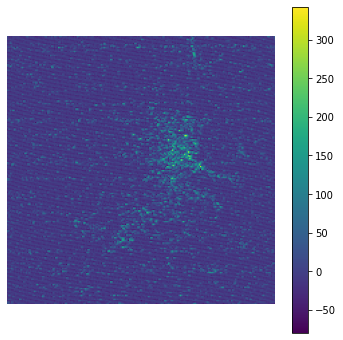

In [115]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cb = ax.imshow(stack4dMC[10,3,:,:],cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb)
ax.axis('off')

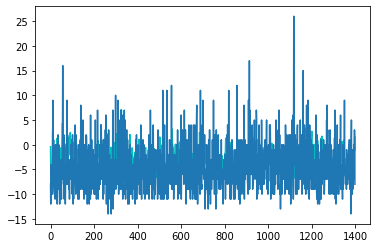

In [134]:
plt.plot(filtF, 'c')
plt.plot(filtStack[:,p,x,y])

In [148]:
dffStack4dMC = np.zeros((stack4dMC.shape)) 

filtStack = stack4dMC# gaussian_filter(stack4dMC, sigma=[0,0,2,2])
#filtStack = filtStack + np.min(filtStack)

for p in range(stack4dMC["planes [µm]"].size):
    for x in range(stack4dMC["xpix [µm]"].size):
        for y in range(stack4dMC["ypix [µm]"].size):
        
            if mask3D.data[p,x,y] == 0:
                continue

            filtF = savgol_filter(filtStack[:,p,x,y], window, order)

            # Estimate baseline
            F0 = np.percentile(filtF, baseLinePercent)
            if F0 == 0: F0 += offset

            # Compute dF/F_0 = (F_raw - F_0)/F_0
            dFF = (filtF - F0) / F0

            dffStack4dMC[:,p,x,y] = dFF

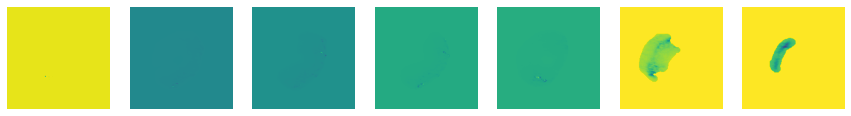

In [151]:
fig, ax = plt.subplots(1,stack4dMC["planes [µm]"].size, figsize=(15,4))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i].imshow(np.median(dffStack4dMC[:,i,:,:],axis=0),cmap='viridis',origin='upper')  
    ax[i].axis('off')

(-0.5, 199.5, 199.5, -0.5)

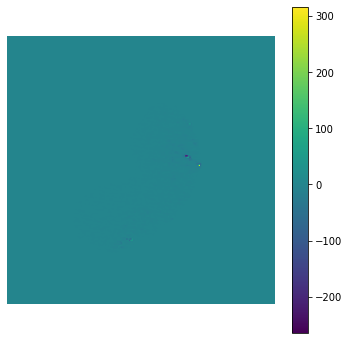

In [152]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cb = ax.imshow(dffStack4dMC[10,3,:,:],cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb)
ax.axis('off')

(-0.5, 199.5, 199.5, -0.5)

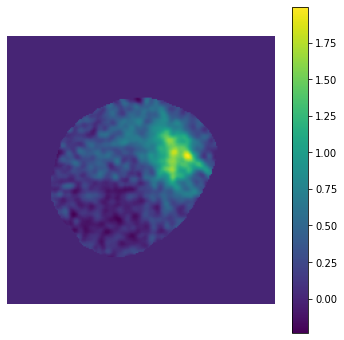

In [154]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cb = ax.imshow(dffStackMC[10,:,:],cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb)
ax.axis('off')

In [155]:
viewerdff1 = napari.view_image(dffStack4dMC)

#### (3) Perform clustering on pixels in mask

TODO: Check time axis generatiton

In [169]:
# Settings
from sklearn.cluster import KMeans

nclst = 9 # 4 for FBt

One plane

In [170]:
toClust = dffStackMC[:,mask.data>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(n_clusters=9)

In [171]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [172]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

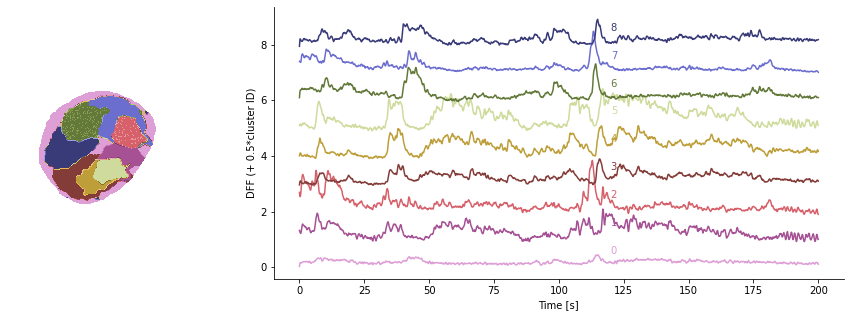

In [173]:
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

cluster: 0 	 meanpos: 106.0
cluster: 1 	 meanpos: 86.0
cluster: 2 	 meanpos: 109.0
cluster: 3 	 meanpos: 62.0
cluster: 4 	 meanpos: 59.0
cluster: 5 	 meanpos: 71.0
cluster: 6 	 meanpos: 122.0
cluster: 7 	 meanpos: 130.0
cluster: 8 	 meanpos: 93.0


<ipython-input-176-7902c62a8df7>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


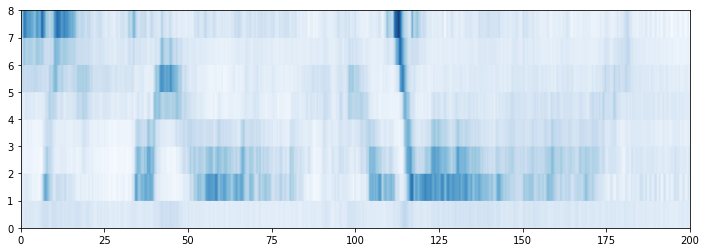

In [176]:
ypos = np.repeat(np.arange(mask.data.shape[0]),mask.data.shape[1]).reshape(mask.data.shape)
yPosClust = np.zeros(nclst)
for i in range(nclst):
    yPosClust[i] = mask.data.shape[0]-np.median(ypos[kmlabsImg==i])
    print('cluster: {} \t meanpos: {}'.format(i,yPosClust[i]))
    
centroidPerm = [0,5,4,3,8,6,7,2,1]#np.argsort(yPosClust)#
centroids2Plot = centroids[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
#fig.savefig(saveDir+sep+tiffName[:-4]+'_dffReordered_cluster_n{}.pdf'.format(nclst))

Volume

In [161]:
nclst = 9 #5
toClust = dffStack4dMC[:,mask3D.data>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(n_clusters=9)

In [162]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [163]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

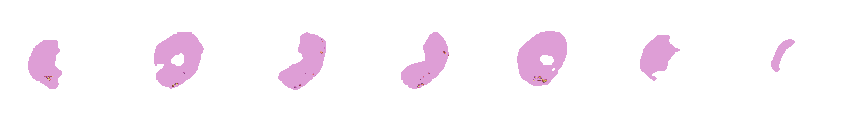

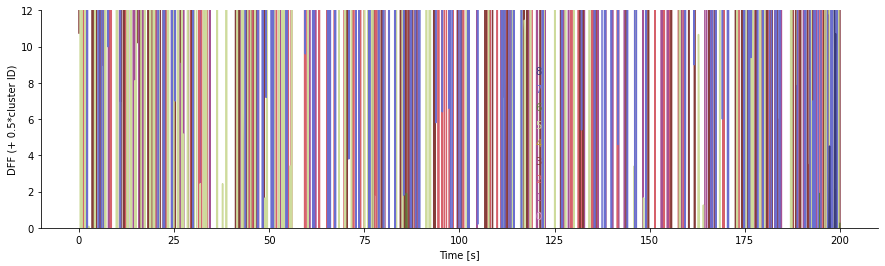

In [164]:
kmlabsImg = np.nan*np.ones(mask3D.data.shape)

kmlabsImg[mask3D.data>0] = kmlabs

fig, axs = plt.subplots(1,stack4dMC["planes [µm]"].size,figsize=(15,6))
for p in range(stack4dMC["planes [µm]"].size):
    axs[p].imshow(kmlabsImg[p,:,:],cmap=myClstMap,origin='upper')
    axs[p].axis('off')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_rois_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

fig, axs = plt.subplots(1,1,figsize=(15,4))
for i in range(nclst):
    axs.plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    axs.text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs.set_xlabel('Time [s]')
axs.set_ylabel('DFF (+ 0.5*cluster ID)')
axs.set_ylim(0, 3+nclst)
myAxisTheme(axs)

fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

### Draw ROI and extract time series from wedges
#### Open registered image stack or reference image in napari and draw roi guides

In [38]:
%gui qt5

viewer = napari.view_image(refImgFilt)

#### Draw guide lines for EB roi segmentation
* draw an outline of the EB (free hand form) -> name "EBoutline"
* draw two lines marking the axes of the ellipse (line forms) -> name "EBlongaxis" and "EBshortaxis"

In [ ]:
# you can also draw a mask:
#ebfill = viewer.layers["EBfill"]
#fig, ax = plt.subplots(1,1,figsize=(5,5))
#ax.imshow(refImg,cmap='Greys_r', vmin=0, origin='upper')
#ax.axis('off');
#ax.imshow(ebfill.data, cmap='Reds', alpha=0.2)
#ebfill.data

In [ ]:
ebouter = viewer.layers["EBoutline"].data[0]
eblongax = viewer.layers["EBlongaxis"].data[0]
ebshortax = viewer.layers["EBshortaxis"].data[0]
print(ebshortax)

#### Generate shapely-objects to represent ROIs

In [ ]:
EBroiRing = LinearRing(ebouter)
EBroiPoly = Polygon(ebouter)
EBaxisL = LineString(eblongax)
EBaxisS = LineString(ebshortax)

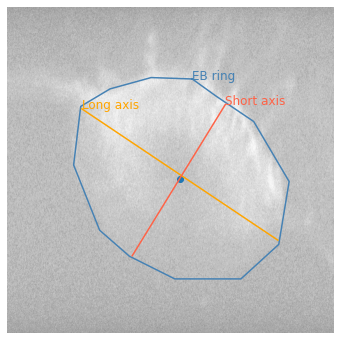

In [112]:
fig, axs = plt.subplots(1,1, figsize=(6,6))

axs.imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', vmin=0, origin='lower')

axs.plot(EBroiRing.coords.xy[0],EBroiRing.coords.xy[1], color='steelblue')
axs.text(EBroiRing.coords[0][0], EBroiRing.coords[0][1], 'EB ring', color='steelblue', fontsize=12)
axs.plot(EBroiRing.centroid.coords.xy[0],EBroiRing.centroid.coords.xy[1],'o')
axs.plot(EBaxisL.coords.xy[0], EBaxisL.coords.xy[1], color='orange')
axs.text(EBaxisL.coords[0][0], EBaxisL.coords[0][1], 'Long axis', color='orange', fontsize=12)
axs.plot(EBaxisS.coords.xy[0], EBaxisS.coords.xy[1], color='tomato')
axs.text(EBaxisS.coords[0][0], EBaxisS.coords[0][1], 'Short axis', color='tomato', fontsize=12)
axs.set_aspect('equal')
axs.axis('off');

In [113]:
ellipseCntr = EBroiRing.centroid.coords[0]
print('EB center coordinates (px): {0}'.format(ellipseCntr))

print('EB axis lengths:  axis 1 = {0}, axis 2 = {1}'.format(round(EBaxisL.length/2.), round(EBaxisS.length/2.)))

axvec = abs(np.asarray(EBaxisL.coords[0])-np.asarray(EBaxisL.coords[1]))
ellipseRot = 90-np.arctan(axvec[0]/axvec[1])*180/np.pi
print('EB main axis rotation (deg): {0}'.format(round(ellipseRot)))

EB center coordinates (px): (271.1316951355634, 240.94755484082148)
EB axis lengths:  axis 1 = 185, axis 2 = 139
EB main axis rotation (deg): 34


In [114]:
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
ellipse = (ellipseCntr,(EBaxisL.length/2., EBaxisS.length/2.),ellipseRot)

# Let create a circle of radius 1 around center point:
circ = sp.geometry.Point(ellipse[0]).buffer(1)

# Let create the ellipse along x and y:
ell  = sp.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (counterclockwise, x axis pointing right):
ell = sp.affinity.rotate(ell,-ellipse[2])
# According to the man, a positive value means a anti-clockwise angle,
# and a negative one a clockwise angle.

EBoutline = ell.exterior

In [132]:
# Find points on EB outline
nsteps = 16#8
EBroiPts = [ellipseCntr]

for s in range(nsteps):
    [sx,sy] = EBoutline.interpolate(s/nsteps, normalized=True).coords.xy
    EBroiPts.append((sx[0],sy[0]))
    
# Shift ROI pts circularely to start at ventral part of EB
st = 3#1
EBroiPtsCopy = EBroiPts.copy()

for s in range(1,nsteps+1):
    EBroiPts[s] = EBroiPtsCopy[(s+st)%nsteps+1]

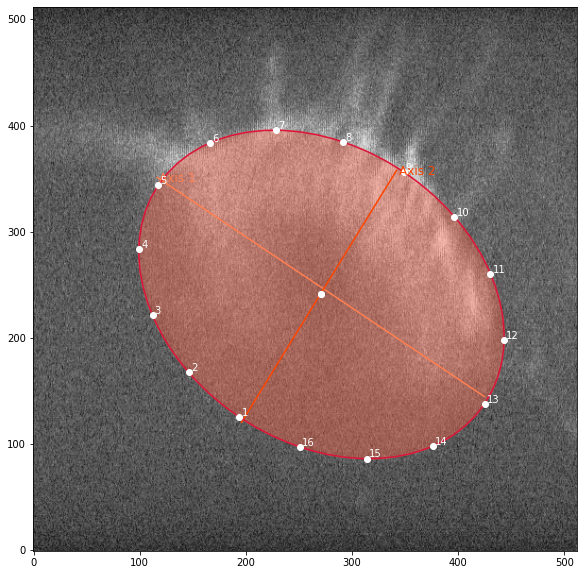

In [133]:
fig, axs = plt.subplots(1,1, figsize=(10,10))

#axs.imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', origin='upper')
axs.imshow(refImg.T,cmap='Greys_r',origin='lower')

patch = ppatch.Ellipse(ellipseCntr, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')
axs.add_patch(patch)
axs.plot(EBaxisL.coords.xy[0], EBaxisL.coords.xy[1], color='coral')
axs.text(EBaxisL.coords[0][0]+2, EBaxisL.coords[0][1]-4, 'Axis 1', color='coral', fontsize=12)
axs.plot(EBaxisS.coords.xy[0], EBaxisS.coords.xy[1], color='orangered')
axs.text(EBaxisS.coords[0][0]+2, EBaxisS.coords[0][1]-4, 'Axis 2', color='orangered', fontsize=12)

axs.plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='crimson')
axs.plot(EBroiPts[0][0],EBroiPts[0][1], 'wo')

for s in range(nsteps):
    axs.plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'wo')
    axs.text(EBroiPts[s+1][0]+2,EBroiPts[s+1][1]+1, str(s+1), color='w')
axs.plot(ellipseCntr[0],ellipseCntr[1],'wo')

In [134]:
EBroiPolys = []
for s in range(nsteps):
    if s+1==nsteps:
        EBroiPolys.append([EBroiPts[0],EBroiPts[s+1],EBroiPts[1]])
    else:
        EBroiPolys.append([EBroiPts[0],EBroiPts[s+1],EBroiPts[s+2]])

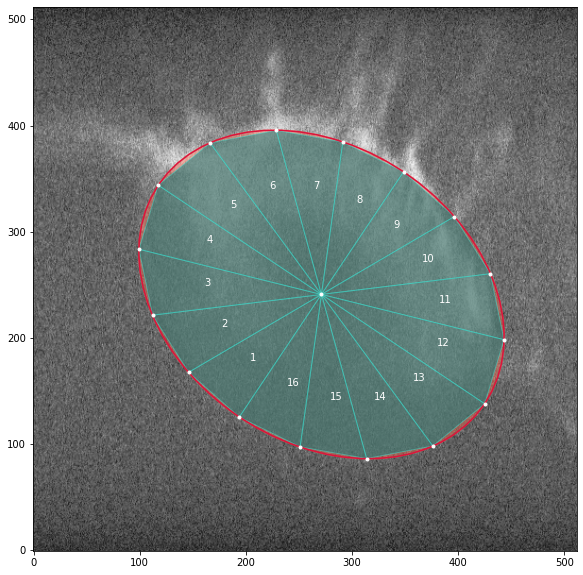

In [135]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
axs.imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', origin='lower')

#patch = PolygonPatch(ell, alpha = 0.3, color='tomato')
EBpatch = ppatch.Ellipse(ellipseCntr, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')

axs.add_patch(EBpatch)
axs.plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='crimson')

for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.5, edgecolor='turquoise', facecolor='teal')
    axs.add_patch(roiPatch)
    labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
    axs.text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')
    axs.plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
axs.plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')

In [136]:
# create a list of possible pixel coordinates
imgrid = np.meshgrid(np.arange(0,stackMPMC.shape[1]), np.arange(0,stackMPMC.shape[2]))
pxcoords = list(zip(*(c.flat for c in imgrid)))


# Get all points in EB ellipse
EBPatch = ppatch.Polygon(EBroiPts[1:])
roiPts_x = [p[0] for p in pxcoords if EBPatch.contains_point(p, radius=0)]
roiPts_y = [p[1] for p in pxcoords if EBPatch.contains_point(p, radius=0)]

EBCoords = np.vstack((roiPts_x,roiPts_y))

# List for all roi point lists
EBroiCoords = []

for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s])

    # create the list of valid coordinates (from untransformed)
    roiPts_x = [p[0] for p in pxcoords if roiPatch.contains_point(p, radius=0)]
    roiPts_y = [p[1] for p in pxcoords if roiPatch.contains_point(p, radius=0)]
    EBroiCoords.append(np.vstack((np.asarray(roiPts_x),np.asarray(roiPts_y))))
    
len(EBroiCoords)

16

In [137]:
# Gaussian-filter each frame before computing DF/F
#gaussianSize = (2, 2)
gaussianSigma = 2

stackMPGFilt = np.zeros((stackMP.shape))

for i in range(nVols):
    stackMPGFilt[i,:,:] = gaussian_filter(stackMPMC[i,:,:], gaussianSigma, mode='reflect')
    

In [124]:
viewer2 = napari.view_image(stackMPGFilt)

In [138]:
# Currently F_0 is estimated for the whole time series 
# (ok, if time series is short but should really be computed in moving window)
baseLinePercent = 10
offset = 0.0001

EBtraces = np.zeros((nsteps,stackMPGFilt.shape[0]))
for s in range(nsteps):
    Fraw = stackMPGFilt[:,EBroiCoords[s][0],EBroiCoords[s][1]].mean(1)
    
    # Estimate baseline
    F0 = np.percentile(Fraw, baseLinePercent)
    if F0 == 0: F0 += offset
    
    # Compute dF/F_0 = (F_raw - F_0)/F_0
    dFF = (Fraw - F0) / F0
    
    EBtraces[s,:] = dFF
    
EBFraw = stackMPGFilt[:,EBCoords[0,:],EBCoords[1,:]].mean(1)
    
# Estimate baseline
EBF0 = np.percentile(EBFraw, baseLinePercent)
if EBF0 == 0: EBF0 += offset
    
# Compute dF/F_0 = (F_raw - F_0)/F_0
EBdFF = (EBFraw - EBF0) / EBF0
    
time = np.linspace(0, nVols/vps, nVols)

In [139]:
# filter DF/F trace with Savitzky-Golay filter
# 3rd order, 7 frames
from scipy.signal import savgol_filter

order = 3
window = 7

EBtracesFilt = np.zeros((nsteps,stackMPMC.shape[0]))

for s in range(nsteps):
    filtDFF = savgol_filter(EBtraces[s,:], window, order)
    EBtracesFilt[s,:] = filtDFF
    

<ipython-input-140-c3c8b7d8608d>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = axs[1].pcolor(time,np.arange(0,nsteps+1),EBtracesFilt,cmap='Blues', edgecolors='face')


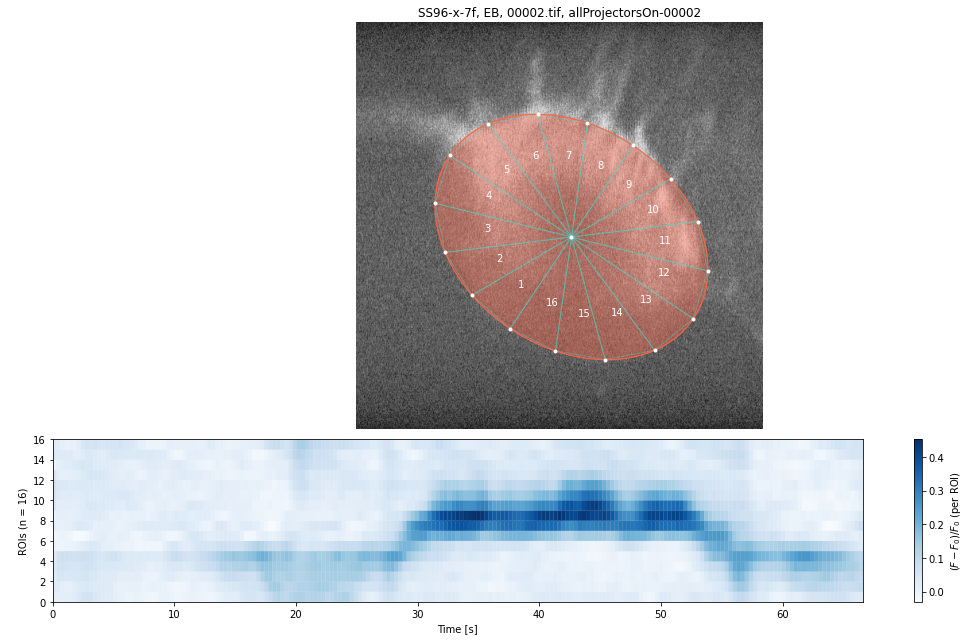

In [140]:
fig, axs = plt.subplots(2,1, figsize=(15,9),gridspec_kw={'height_ratios':[2.5,1]})

axs[0].imshow(np.mean(stackMP,axis=0).T,cmap='Greys_r', origin='lower')#, vmin=0, vmax=0.7*np.max(stackMP))

#patch = PolygonPatch(ell, alpha = 0.3, color='tomato')
patch = ppatch.Ellipse(ellipseCntr, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')

axs[0].add_patch(patch)
axs[0].plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='tomato', linewidth=1)

for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.4, edgecolor='turquoise', facecolor='none')
    axs[0].add_patch(roiPatch)
    axs[0].plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
    labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
    axs[0].text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')

axs[0].plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')
axs[0].axis('off')
axs[0].set_title(', '.join([genotype, region, condition, date+'-'+trial]))

#cax = axs[1].imshow(EBtraces,cmap='Blues', aspect=20, interpolation='None', origin='lower', vmin=0)
cax = axs[1].pcolor(time,np.arange(0,nsteps+1),EBtracesFilt,cmap='Blues', edgecolors='face')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('\nROIs (n = {0})'.format(nsteps))
#myAxisTheme(axs[1])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar

fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['roiMap-dFFtimeseries',genotype, region, flyID, age, condition, trial])+'.pdf')

#### Save ROI time series

#### Compute PVA

In [433]:
def computePVA (locs, weights):
    """ Compute population vector average
    """
    nsteps = weights.shape[0]
    nvol = weights.shape[1]
    pva_x = np.cos(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    pva_y = np.sin(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    
    pva = np.vstack((sum(pva_x)/len(pva_x), sum(pva_y)/len(pva_x)))
    return pva

In [437]:
roiArcPos = np.linspace(0, 2*np.pi, nsteps+1)[:-1]

pva = computePVA(roiArcPos,EBtracesFilt)
pvaRad = np.arctan2(pva[1,:],pva[0,:])
pvaLen = np.hypot(pva[0,:],pva[1,:])

PVAst = 3#7.5
pvaRoi = np.mod((np.unwrap(pvaRad,np.pi) - pvaRad[0]) * nsteps/(2*np.pi) + PVAst, nsteps)

In [438]:
#plt.plot(time, computePVA(roiArcPos,EBtraces)[0],'k')
#plt.plot(time, computePVA(roiArcPos,EBtracesFilt)[0],'c')

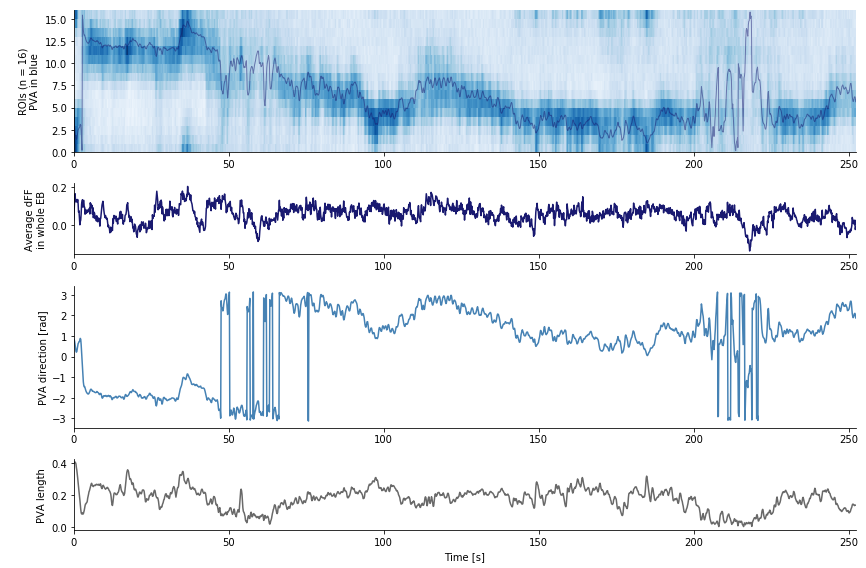

In [439]:
fig, axs = plt.subplots(4,1, figsize=(12,8),gridspec_kw={'height_ratios':[1,0.5, 1, 0.5]})
cax = axs[0].pcolor(time,np.arange(0,nsteps+1),EBtracesFilt,cmap='Blues', edgecolors='face')
axs[0].set_ylabel('\nROIs (n = {0})\nPVA in blue'.format(nsteps))
axs[0].plot(time,pvaRoi,'-', color='midnightblue', linewidth=1, alpha=0.5)


axs[1].plot(time,EBdFF,color='midnightblue')
axs[1].set_ylabel('Average dFF\nin whole EB')

axs[2].plot(time,pvaRad,color='steelblue')
axs[2].set_ylabel('PVA direction [rad]')
axs[3].plot(time,pvaLen,color='dimgrey')
axs[3].set_ylabel('PVA length')
axs[3].set_xlabel('Time [s]')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlim(time[0],time[-1])
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['dFFandPVA',genotype, region, flyID, age, condition, trial, date])+'.pdf')

## Load in position data

In [440]:
posDataMat = rawTiff[:-3]+'mat'
print(posDataMat)

GCaMP7f_x_SS96_f02_7-8d_clutterWGroundAndCyli_00004.mat


In [441]:
matstruct = sio.loadmat(dataDir+sep+posDataMat)
posDat = matstruct['positionDat']

In [442]:
print('For each loged time point, the following parameters are reported:')
print(posDat[0,][0].dtype)

For each loged time point, the following parameters are reported:
[('t', 'O'), ('OffsetRot', 'O'), ('OffsetFor', 'O'), ('OffsetLat', 'O'), ('dx0', 'O'), ('dx1', 'O'), ('dy0', 'O'), ('dy1', 'O'), ('closed', 'O'), ('direction', 'O'), ('trans', 'O'), ('olgain', 'O'), ('clgain', 'O'), ('exType', 'O'), ('tFrameGrab', 'O'), ('tVR', 'O')]


In [443]:
tmtime = np.ndarray.flatten(posDat[0,0][0])
print(len(tmtime))

osRot = np.ndarray.flatten(posDat[0,0][1])
osFwd = np.ndarray.flatten(posDat[0,0][2])
osLat = np.ndarray.flatten(posDat[0,0][3])

dx0 = np.ndarray.flatten(posDat[0,0][4])
dx1 = np.ndarray.flatten(posDat[0,0][5])
dy0 = np.ndarray.flatten(posDat[0,0][6])
dy1 = np.ndarray.flatten(posDat[0,0][7])

tFrameGrab = np.ndarray.flatten(posDat[0,0][14][0])
print(len(tFrameGrab))
tVR = np.ndarray.flatten(posDat[0,0][15][0])
print(len(tVR))

29513
21248
61896


In [444]:
minFG = np.floor(np.where(tFrameGrab >= tVR[0])[0][0]/fpv)
maxFG = np.round(len(tFrameGrab)/fpv)
FG = (int(minFG), int(maxFG))

In [445]:
def interpFrames(rawDat, FG, fpv, time, framegrab, tVR):

    interpDat = np.zeros((FG[1]-FG[0], 1))
    
    for i in range(FG[0],FG[1]):
        
        iMatch = np.where( time >= ( time[0] + (framegrab[(i-1)*fpv+1] - tVR[0])/10000 ) )[0][0]
        interpDat[i - FG[0]] = rawDat[iMatch]
    
    return interpDat

In [446]:
timeMatched = tFrameGrab[0::fpv]/10000
timeMatched = timeMatched[FG[0]:FG[1]]
print(len(timeMatched))

tmtimeMatch = np.ndarray.flatten(interpFrames(tmtime,FG, fpv, tmtime, tFrameGrab, tVR)) 
osRotMatch = np.ndarray.flatten(interpFrames(osRot,FG, fpv, tmtime, tFrameGrab, tVR))
osFwdMatch = np.ndarray.flatten(interpFrames(osFwd,FG, fpv, tmtime, tFrameGrab, tVR))
osLatMatch = np.ndarray.flatten(interpFrames(osLat,FG, fpv, tmtime, tFrameGrab, tVR))

dx0Match = np.ndarray.flatten(interpFrames(dx0,FG, fpv, tmtime, tFrameGrab, tVR))
dx1Match = np.ndarray.flatten(interpFrames(dx1,FG, fpv, tmtime, tFrameGrab, tVR))
dy0Match = np.ndarray.flatten(interpFrames(dy0,FG, fpv, tmtime, tFrameGrab, tVR))
dy1Match = np.ndarray.flatten(interpFrames(dy1,FG, fpv, tmtime, tFrameGrab, tVR))

1755


In [447]:
vFwdMatched = np.hstack((0,abs(np.diff(osFwdMatch))/np.diff(timeMatched)))
#vFwdMatched[vFwdMatched>2] = np.nan

vTransMatched = np.hypot(osFwdMatch, osLatMatch)
vTransMatched = np.hstack((0,abs(np.diff(vTransMatched))/np.diff(timeMatched)))

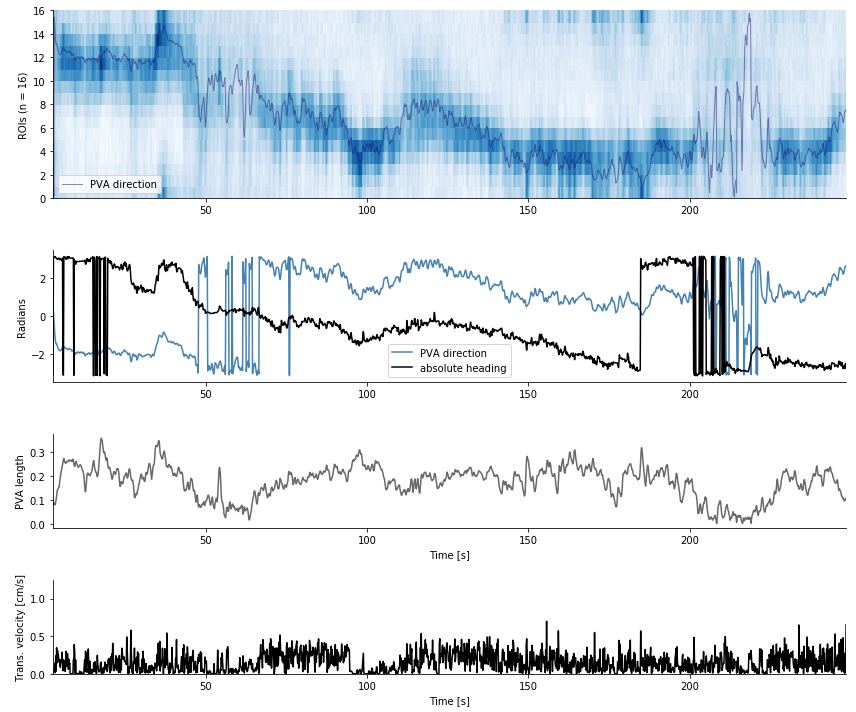

In [448]:
EBtracesMatched = EBtracesFilt[:,FG[0]:FG[1]]
pvaRoiMatched = pvaRoi[FG[0]:FG[1]]
pvaRadMatched = pvaRad[FG[0]:FG[1]]
pvaLenMatched = pvaLen[FG[0]:FG[1]]

from roiVisualization import myAxisTheme

fig, axs = plt.subplots(4,1, figsize=(12,10),gridspec_kw={'height_ratios':[1,0.7, 0.5, 0.5]})
cax = axs[0].pcolor(timeMatched,np.arange(0,nsteps+1),EBtracesMatched,cmap='Blues', edgecolors='face')
axs[0].set_ylabel('\nROIs (n = {0})'.format(nsteps))
axs[0].plot(timeMatched,pvaRoiMatched,'-', color='midnightblue', linewidth=1, alpha=0.5, label='PVA direction')
axs[0].legend()

axs[1].plot(timeMatched,pvaRadMatched,color='steelblue', label='PVA direction')
axs[1].plot(timeMatched,osRotMatch*np.pi/180.,color='black', label='absolute heading')
axs[1].set_ylabel('Radians')
axs[1].legend()

axs[2].plot(timeMatched,pvaLenMatched,color='dimgrey', label='PVA length')
axs[2].set_ylabel('PVA length')
axs[2].set_xlabel('Time [s]')

axs[3].plot(timeMatched,vTransMatched,color='black', label='transl. velocity')
axs[3].set_ylim(0,1.25)
axs[3].set_ylabel('Trans. velocity [cm/s]')
axs[3].set_xlabel('Time [s]')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlim(timeMatched[0],timeMatched[-1])
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['DFF-PVA-heading-fwdvelo', genotype, region, flyID, age, condition, trial, date])+'.pdf')

#### Relate PVA to relative heading (w.r.t. local landmark)

In [449]:
LMcoords = (0,0)

In [450]:
def dotproduct2d(a, b):
    # 2D dot product
    return a[0, :]*b[0, :] + a[1, :]*b[1, :]


def veclength2d(vec):
    return np.sqrt(vec[0, :]**2 + vec[1, :]**2)


def relationToObject(time, xPos, yPos, angle, objLocation):
    # Assumes only one object, thus in case of fly VR one needs to use the projected xPosMA

    # Vector to object location
    objDirection = np.vstack((objLocation[0]-xPos, objLocation[1]-yPos))

    objDistance = np.hypot(objLocation[0]-xPos, objLocation[1]-yPos)

    # Fly orientation vector
    flyDirection = np.vstack((np.cos(angle), np.sin(angle)))

    # Angle to object relative from fly's orientation
    lenFlyVec = np.hypot(flyDirection[0, :], flyDirection[1, :])
    lenObjVec = np.hypot(objDirection[0, :], objDirection[1, :])

    gamma = np.arccos(dotproduct2d(flyDirection, objDirection) / (lenFlyVec * lenObjVec))

    gammaFull = np.arctan2(flyDirection[1, :], flyDirection[0, :])-np.arctan2(objDirection[1, :], objDirection[0, :])
    gammaFull[gammaFull < 0] += 2 * np.pi
    gammaFull[gammaFull > np.pi] -= 2 * np.pi

    gammaV = np.hstack((np.diff(gamma)/np.diff(time), 0))

    return objDirection, objDistance, gammaFull, gamma, gammaV

In [451]:
_, LMdist, gamma, gammahalf, _ = relationToObject(tmtimeMatch, osFwdMatch, osLatMatch, osRotMatch*np.pi/180., LMcoords)

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [460]:
# Change offset of PVA to match either abs. or rel. heading trace
PVAst = 0.2#-0.8
pvaPlot = np.mod((np.unwrap(pvaRadMatched,np.pi) + PVAst), np.pi*2) - np.pi

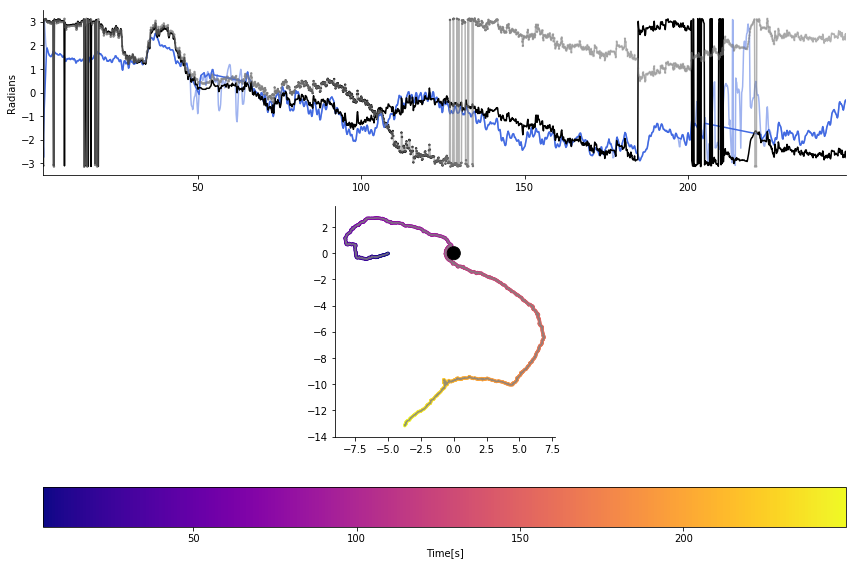

In [461]:
localLM = True
pvaLenTH = 0.1

fig, axs = plt.subplots(2,1, figsize=(12,8),gridspec_kw={'height_ratios':[1,2]})
axs[0].plot(timeMatched,pvaPlot,color='royalblue', alpha=0.5)
axs[0].plot(timeMatched[pvaLenMatched>pvaLenTH],pvaPlot[pvaLenMatched>pvaLenTH],color='royalblue', alpha=1, label='PVA direction')
#axs[0].plot(timeMatched,pvaRadMatched,color='royalblue', alpha=1, label='PVA direction')
#axs[0].scatter(timeMatched,pvaRadMatched, s=5, c=tmtimeMatch, cmap='plasma')
axs[0].plot(timeMatched,osRotMatch*np.pi/180.,color='black', label='absolute heading')
if localLM:
    axs[0].plot(timeMatched,gamma,color='grey',alpha=0.6, label='relative (LM) heading')
    axs[0].scatter(timeMatched,gamma,s=2, c=LMdist, cmap='Greys_r')
axs[0].set_ylabel('Radians')
#axs[0].legend()
axs[0].set_xlim(timeMatched[0],timeMatched[-1])

#cb = axs[1].scatter(osFwdMatch, osLatMatch, s=5, c=osRotMatch*np.pi/180, cmap='hsv')
axs[1].plot(osFwdMatch, osLatMatch,color='grey', alpha=0.8)
cb = axs[1].scatter(osFwdMatch, osLatMatch, s=5, c=tmtimeMatch, cmap='plasma')
plt.colorbar(cb, ax=axs[1], orientation='horizontal', label='Time[s]')
axs[1].set_aspect('equal')

if localLM:
    # add landmark
    from matplotlib.patches import Circle
    circle = Circle((0, 0), 0.5, color='black')
    axs[1].add_artist(circle)
    #axs[1].set_xlim(-10,5)

for ax in axs:
    myAxisTheme(ax)
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['PVA-absHead-relHead-traj',genotype, region, flyID, age, condition, trial, date])+'.pdf')